In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, GRU, BatchNormalization,Input
from tensorflow.keras.layers import Embedding, Concatenate, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import ELU


from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2022-07-29 07:01:42.621544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 07:01:42.740487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 07:01:42.741218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 07:01:42.747228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Number of devices: 1


In [3]:
data = pd.read_csv('../input/paddy-disease-classification/train.csv')
data.shape

(10407, 4)

In [4]:
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [5]:
data.label.unique()

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype=object)

In [6]:
num_class = len(data.label.unique())
display("Number of classes:",num_class)

'Number of classes:'

10

In [7]:
img_rows, img_cols = 256, 256
batch_size = 300 * strategy.num_replicas_in_sync

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [9]:


data['label'] = data['label'].astype('str')
data['variety'] = data['variety'].astype('str')



In [10]:
data.describe()

,age
count,10407.000000
mean,64.043624
std,8.958830
min,45.000000
25%,60.000000
50%,67.000000
75%,70.000000
max,82.000000


In [11]:
data['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

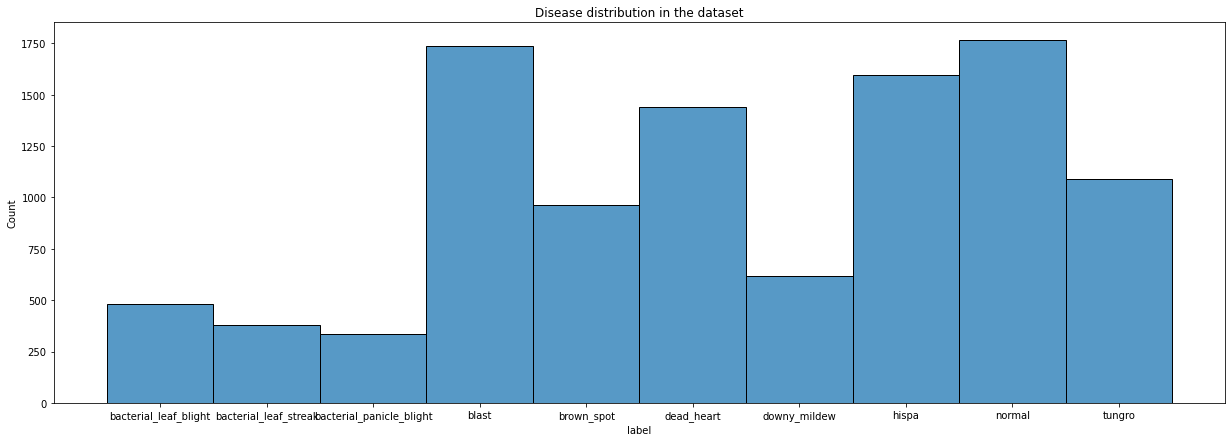

In [12]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='label',bins=10,ax=axes)
plt.title('Disease distribution in the dataset')
plt.show()

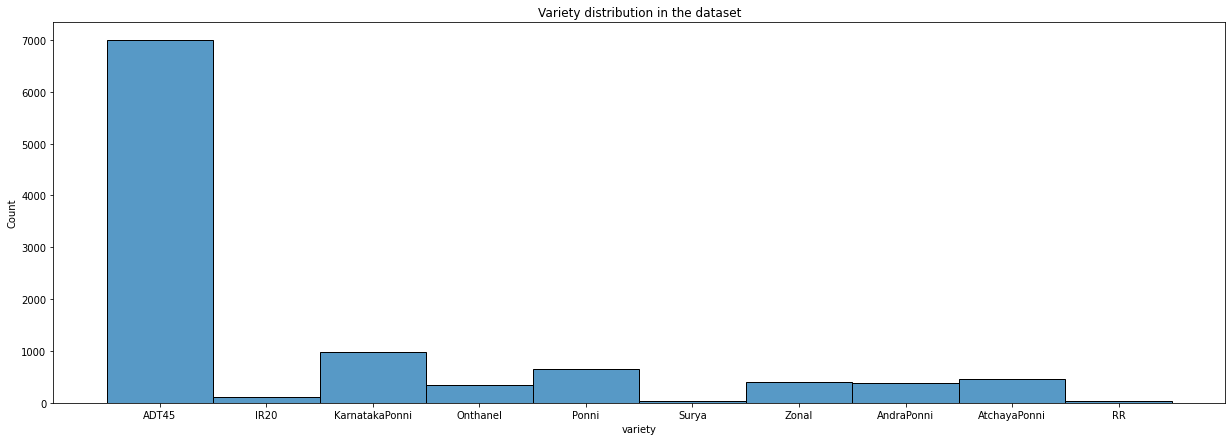

In [13]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='variety',ax=axes)
plt.title('Variety distribution in the dataset')
plt.show()

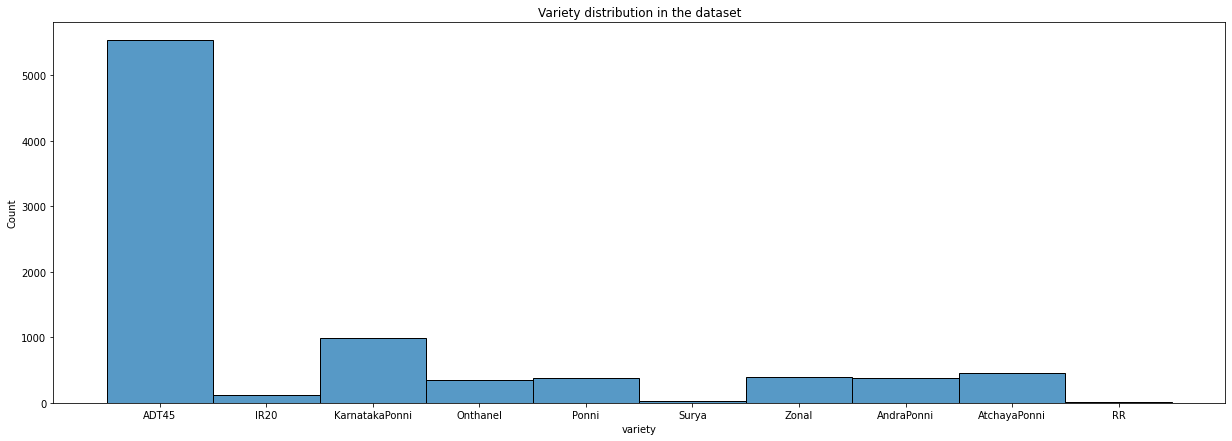

In [14]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data[data['label']!='normal'],x='variety',ax=axes)
plt.title('Variety distribution in the dataset')
plt.show()

In [15]:
data[data['label']!='normal']['variety'].value_counts()

ADT45             5535
KarnatakaPonni     988
AtchayaPonni       461
Zonal              399
AndraPonni         377
Ponni              376
Onthanel           343
IR20               114
Surya               32
RR                  18
Name: variety, dtype: int64

In [16]:


images = ['../input/paddy-disease-classification/train_images/hispa/106590.jpg',\
          '../input/paddy-disease-classification/train_images/tungro/109629.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_blight/109372.jpg',\
          '../input/paddy-disease-classification/train_images/downy_mildew/102350.jpg',\
          '../input/paddy-disease-classification/train_images/blast/110243.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_streak/101104.jpg',\
          '../input/paddy-disease-classification/train_images/normal/109760.jpg',\
          '../input/paddy-disease-classification/train_images/brown_spot/104675.jpg',\
          '../input/paddy-disease-classification/train_images/dead_heart/105159.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_panicle_blight/101351.jpg',\
         ]
diseases = ['hispa','tungro','bacterial_leaf_blight','downy_mildew','blast','bacterial_leaf_streak',\
           'normal','brown_spot','dead_heart','bacterial_panicle_blight']
diseases = [disease +' disease' for disease in diseases]



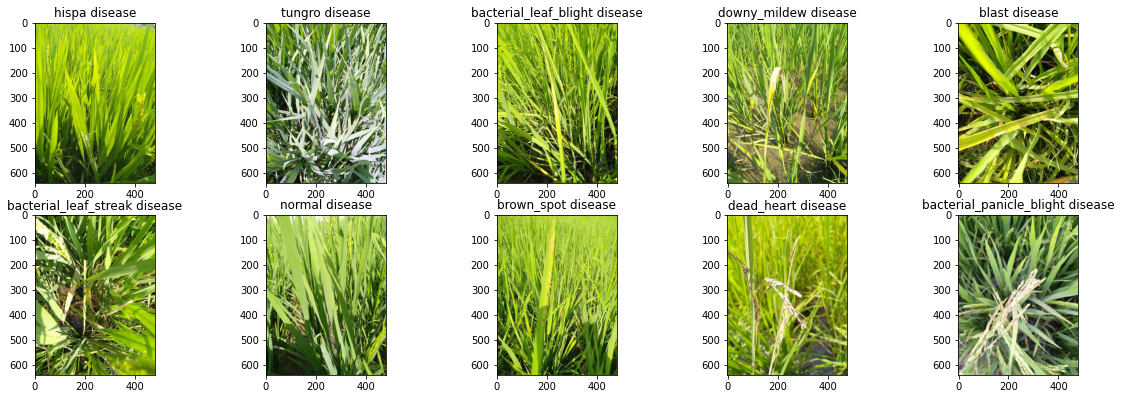

In [17]:
plt.figure(figsize=(20,10))
columns = 5
for i, image_loc in enumerate(images):
    plt.subplot(len(images)//columns + 1, columns, i + 1)
    image=plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

In [18]:
# use data augmentation to improve accuracy and prevent overfitting
aug_gens = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    validation_split=0.1,
    rotation_range=10,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [19]:
train_loc = '../input/paddy-disease-classification/train_images/'
train_data = aug_gens.flow_from_directory(
    train_loc,
    subset="training",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")

Found 9371 images belonging to 10 classes.


In [20]:
valid_data = aug_gens.flow_from_directory(
    train_loc,
    subset="validation",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")

Found 1036 images belonging to 10 classes.


In [21]:
test_loc = '../input/paddy-disease-classification/test_images'
test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=test_loc,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [22]:
print(train_data.class_indices)
print(len(train_data.class_indices))

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
10


In [23]:
leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.01)

[-2.68280104e-03 -6.37735836e-03 -1.48357389e-02 -3.34642546e-02
 -7.19448398e-02 -1.42277620e-01 -2.38405844e-01 -2.68941421e-01
  0.00000000e+00  7.31058579e-01  1.76159416e+00  2.85772238e+00
  3.92805516e+00]


<function matplotlib.pyplot.show(close=None, block=None)>

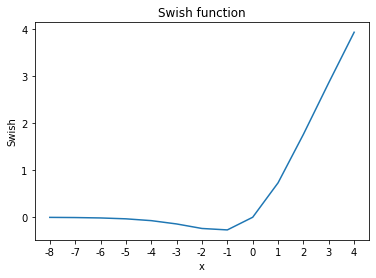

In [24]:
x = np.arange(-8,5)
swish = x/(1+np.exp(-x))
print(swish)
pd.Series(swish).plot(kind='line')
plt.title('Swish function')
plt.xticks(range(len(x)),x)
plt.ylabel('Swish')
plt.xlabel('x')
plt.show


In [25]:
def create_model():
    #tf.keras.backend.clear_session()
    
    input_layer = Input((img_rows,img_cols,3))
    conv2d_1_1 = Conv2D(filters=16, kernel_size=3,strides =(1,1), activation='relu', padding="same", name ="conv2d_branch1")(input_layer)
    maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_1)

    conv2d_1_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
    maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_2)

    conv2d_1_3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
    maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_3)

    conv2d_1_4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
    maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_4)

    flatten = Flatten()(maxpool)
    dense_1 = Dense(1024, activation='swish')(flatten)
    dense_2 = Dense(128, activation='swish')(dense_1)

    output_dense = Dense(num_class, activation="softmax")(dense_2)

    model = Model(inputs=[input_layer], outputs=[output_dense])
    
    return model

In [26]:
with strategy.scope():
    model = create_model()

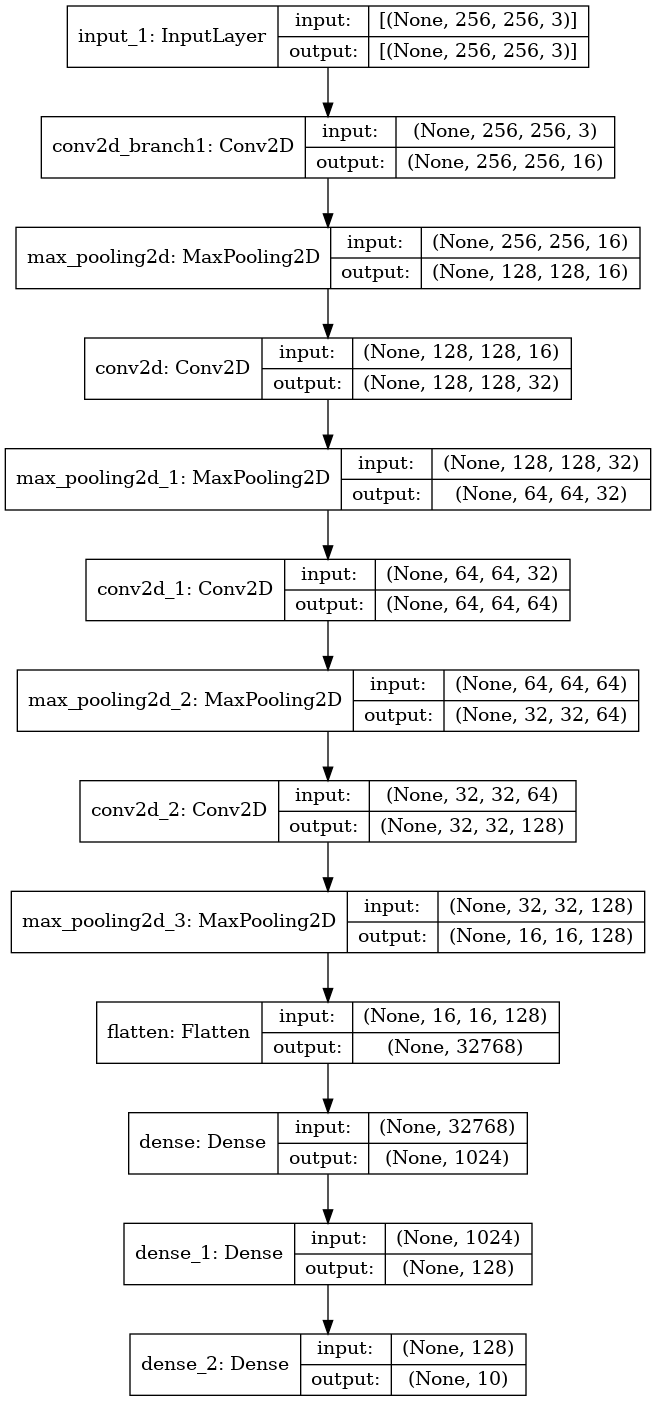

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

In [28]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_branch1 (Conv2D)      (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

In [29]:
EPOCH = 100

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

In [30]:
model.compile(optimizer= 'adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model_fit = model.fit(train_data, epochs=EPOCH ,batch_size = batch_size ,validation_data=valid_data, verbose =1,callbacks=[early_stop,lr_reduction])

2022-07-29 07:01:59.326084: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_320"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
 

Epoch 1/100


2022-07-29 07:02:08.322733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - ETA: 0s - loss: 2.2954 - accuracy: 0.1841

2022-07-29 07:05:35.985779: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1444"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }


32/32 [==============================] - 240s 7s/step - loss: 2.2954 - accuracy: 0.1841 - val_loss: 2.0632 - val_accuracy: 0.2809
Epoch 2/100
32/32 [==============================] - 198s 6s/step - loss: 1.9520 - accuracy: 0.3206 - val_loss: 1.8896 - val_accuracy: 0.3456
Epoch 3/100
32/32 [==============================] - 198s 6s/step - loss: 1.8215 - accuracy: 0.3627 - val_loss: 1.8218 - val_accuracy: 0.3736
Epoch 4/100
32/32 [==============================] - 199s 6s/step - loss: 1.7274 - accuracy: 0.3864 - val_loss: 1.7177 - val_accuracy: 0.4112
Epoch 5/100
32/32 [==============================] - 199s 6s/step - loss: 1.6159 - accuracy: 0.4226 - val_loss: 1.5653 - val_accuracy: 0.4556
Epoch 6/100
32/32 [==============================] - 198s 6s/step - loss: 1.5401 - accuracy: 0.4632 - val_loss: 1.4988 - val_accuracy: 0.4710
Epoch 7/100
32/32 [==============================] - 195s 6s/step - loss: 1.4340 - accuracy: 0.4971 - val_loss: 1.3591 - val_accuracy: 0.5434
Epoch 8/100
32/32 

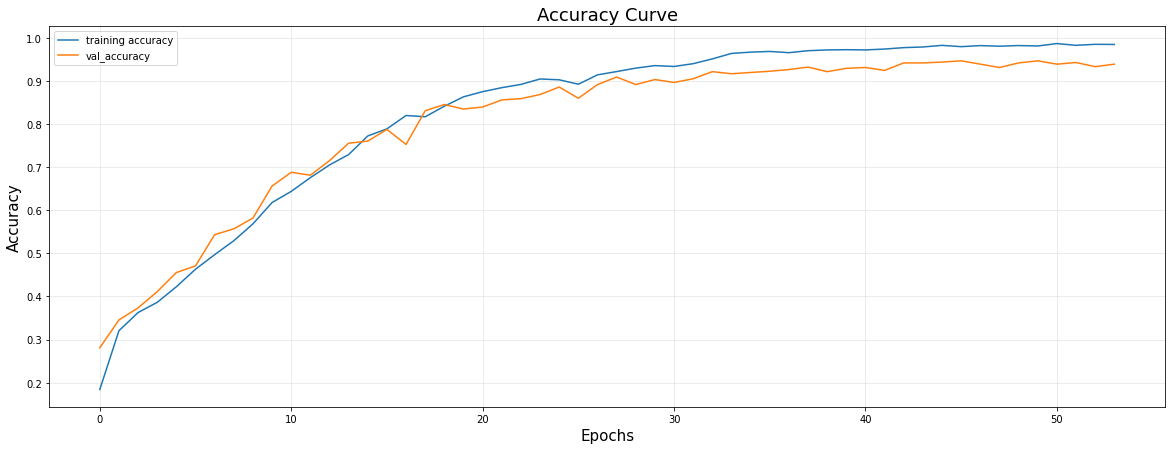

In [31]:
f = plt.figure(figsize=(20,7))

# For Accuracy
plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

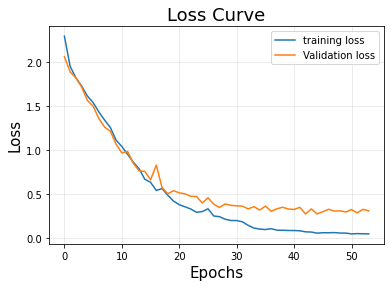

In [32]:
plt.plot(model_fit.epoch,model_fit.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_loss'],label="Validation loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [33]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [34]:
load_model = tf.keras.models.load_model('saved_model/my_model.h5')

In [35]:
evaluate_test = model.evaluate(test_data, verbose=1)
print("\nAccuracy =", "{:.7f}%".format(evaluate_test[1]*100))
print("Loss     =" ,"{:.9f}".format(evaluate_test[0]))

2022-07-29 10:00:03.297216: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_18692"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }

12/12 [==============================] - 43s 4s/step - loss: 160.9005 - accuracy: 0.0470

Accuracy = 4.6987604%
Loss     = 160.900543213


In [36]:
y_predict_max = np.argmax(model.predict(test_data),axis=1)

2022-07-29 10:00:48.998849: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_18899"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }

In [37]:
inverse_map = {v:k for k,v in train_data.class_indices.items()}
predictions = [inverse_map[k] for k in y_predict_max]

files=test_data.filenames
results=pd.DataFrame({"image_id":files,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()


,image_id,label
0,200001.jpg,brown_spot
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
